## Exercise - Model Estimation & Evaluation

This is an exercise on parametric model estimation & model evaluation using a Wines dataset.

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.stats import norm
from scipy.stats import kstest

### Read from CSV File & Preliminary EDA

After reading from the CSV file, perform EDA for `points` and `price`. In particular, we plot the boxplot for points and price for the sample, then do the same for the 5 countries that have the most wines in the sample.

In [3]:
claims_df = pd.read_csv('claims-sample.csv')
claims_df = claims_df[['Claim Amount']]
claims_df.rename(columns={'Claim Amount' : 'claim_amount'}, inplace=True)

In [10]:
lo, hi = np.percentile(claims_df['claim_amount'], [25, 75])
iqr, multiplier = hi-lo, 3
lower_limit, upper_limit = max(0, lo-multiplier*iqr), hi+multiplier*iqr
print(lo, hi)
print(lower_limit, upper_limit)

16.03 278.0
0 1063.91


In [11]:
claims_df = claims_df[claims_df['claim_amount'] <= upper_limit]
claims_df.reset_index(inplace=True, drop=True)

In [12]:
claims_df.sort_values('claim_amount', ascending=True).tail()

,claim_amount
47,960.00
258,989.73
336,1000.00
197,1032.00
208,1060.00


/Users/bryanlim/.pyenv/versions/3.4.8/envs/ds-toolkit/lib/python3.4/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


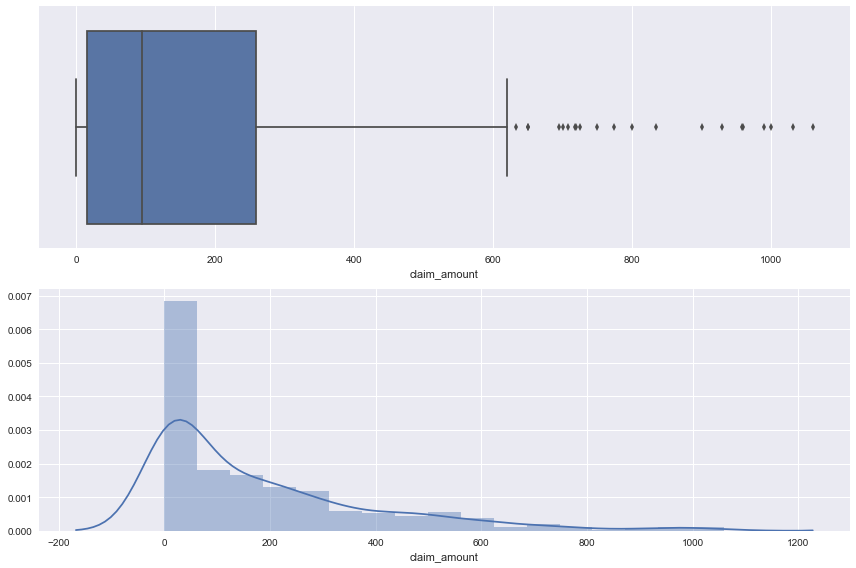

In [13]:
fig = plt.figure(figsize=(12, 8))
ax1, ax2 = fig.add_subplot(211), fig.add_subplot(212)
sns.boxplot(claims_df['claim_amount'], ax=ax1)
sns.distplot(claims_df['claim_amount'], ax=ax2)
plt.tight_layout()
plt.show()

### Model Fitting (Parametric Estimation)

Let's take a look at the wines from the US. For ease of use, we sort them from the lowest to the highest.

In [5]:
us_wines_df = wines_df.copy()
us_wines_df = us_wines_df[us_wines_df.country == 'US']
us_wines_df.reset_index(drop=True, inplace=True)
us_wines_points = us_wines_df['points']
# Sorting from lowest to highest
sorted_us_wines_points = us_wines_points.sort_values(ascending=True)
print(sorted_us_wines_points.tolist()[:30])

[80, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84]


Let's attempt to fit the points of US wines to a normal distribution.

In [6]:
fitted_mu, fitted_sigma = norm.fit(us_wines_points)
print(fitted_mu,fitted_sigma**2)

88.2749445676275 9.74702189271439


The parameters for the fitted normal is $\hat{\mu}=88.275$ and $\hat{\sigma}^2=9.747$. How close is the fitted distribution to the empirical distribution? The fitted distribution is overlayed on the histogram.

In [7]:
# To plot the fitted, use norm.pdf to get the curve.
points_min, points_max = us_wines_points.min(), us_wines_points.max()
points_x = np.linspace(points_min-2, points_max+2, 100)
fitted_pdf = norm.pdf(points_x, fitted_mu, fitted_sigma)
fitted_cdf = norm.cdf(points_x, fitted_mu, fitted_sigma)
fitted_df = pd.DataFrame({'x' : points_x, 
                          'p_hat' : fitted_pdf,
                          'F_hat' : fitted_cdf})
print(fitted_df.head(3))

      F_hat     p_hat         x
0  0.000499  0.000568  78.00000
1  0.000627  0.000702  78.20202
2  0.000784  0.000863  78.40404


/Users/bryanlim/.pyenv/versions/3.4.8/envs/ds-toolkit/lib/python3.4/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


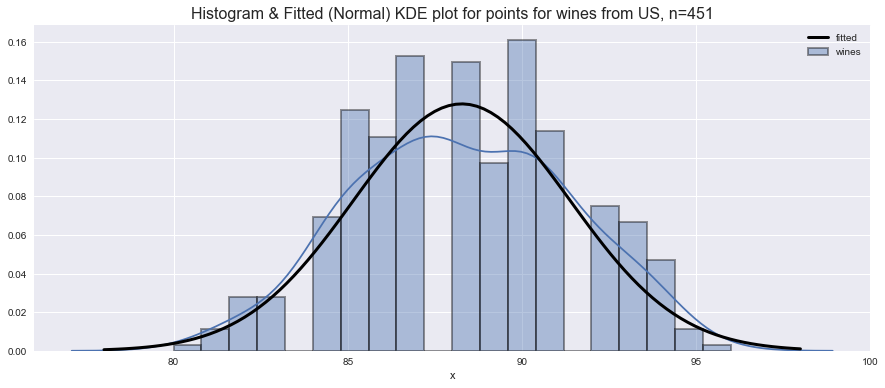

In [8]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Plot the histogram of the empirical distribution
sns.distplot(us_wines_points, bins=20, hist_kws=dict(edgecolor="k", linewidth=2), ax=ax)
# Plot the fitted normal distribution
fitted_df.plot(kind='line', x='x', y='p_hat', linewidth=3, color='black', ax=ax)

ax.set_title("Histogram & Fitted (Normal) KDE plot for points for wines from US, n=%d" % us_wines_points.count(), fontsize=16)
ax.legend(['fitted', 'wines',])
plt.show()

Side note: The kurtosis of the distribution is clearly negative since it has fatter tails and a lower peak.

In [9]:
us_wines_points.kurt()

-0.5696611936314397

### Model Evaluation - Graphical Methods
How well does the normal distribution explain the distribution of the data? Let's look at the CDF plots for both the empirical distribution and fitted distribution first.

In [10]:
empirical_df = pd.DataFrame({'x' : sorted_us_wines_points})
empirical_df.reset_index(inplace=True, drop=True)
empirical_df['i'] = empirical_df.index+1
# For each value of x, find p(X<=x), stored as empirical_p
print('empirical_df.count()=%d' % empirical_df['x'].count())
print('empirical_df[\'x\'].nunique()=%d' % empirical_df['x'].nunique())
print('empirical_df[\'x\'].unique()=%s' % str(empirical_df['x'].unique().tolist()))
empirical_groupby_df = empirical_df.groupby('x')['i'].max().reset_index(name='cum_count')
empirical_groupby_df['F_empirical'] = empirical_groupby_df['cum_count']/empirical_groupby_df['cum_count'].max()

empirical_groupby_df2 = empirical_groupby_df.copy()
# empirical_groupby_df2 = empirical_groupby_df2[:-1]
empirical_groupby_df2['x'] = empirical_groupby_df2['x'].shift(-1)
empirical_groupby_df2 = empirical_groupby_df2[:-1]

empirical_groupby_df = empirical_groupby_df.append(empirical_groupby_df2)
empirical_groupby_df.sort_values(['x', 'F_empirical'], inplace=True)
print(empirical_groupby_df.head())

empirical_df.count()=451
empirical_df['x'].nunique()=17
empirical_df['x'].unique()=[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]
      x  cum_count  F_empirical
0  80.0          1     0.002217
0  81.0          1     0.002217
1  81.0          5     0.011086
1  82.0          5     0.011086
2  82.0         15     0.033259


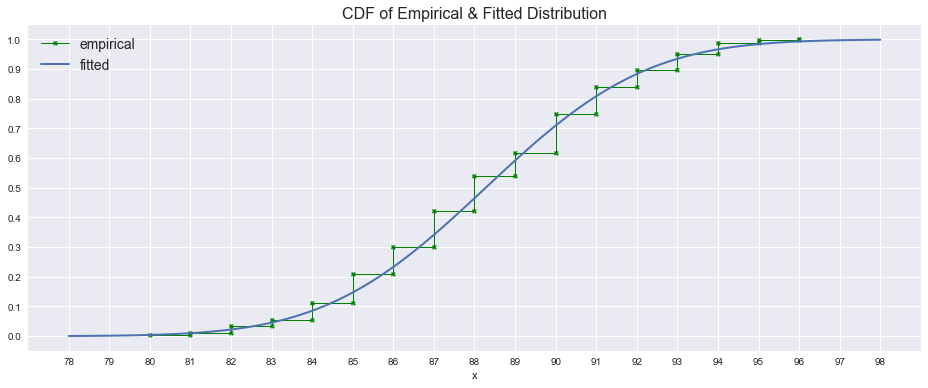

In [11]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
# Plot the empirical CDF
empirical_groupby_df.plot(kind='line', x='x', y='F_empirical', marker='X', ax=ax, markersize=5, linewidth=1, color='green')
# Plot the fitted CDF
fitted_df.plot(kind='line', x='x', y='F_hat', marker='x', ax=ax, linewidth=2)
ax.set_title("CDF of Empirical & Fitted Distribution", fontsize=16)
ax.legend(['empirical', 'fitted'], fontsize=14)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(empirical_groupby_df['x'].min()-2,
                       empirical_groupby_df['x'].max()+3))
plt.show()

**Conclusion**: From the CDF plots, the distribution looks like a good fit, but some clear deviations from the fitted can be seen where $86 \leq x \leq 90$. Hence, we should use other methods to evaluate the validity of the model.

### Graphical Methods - *p-p* Plot

A *p-p* plot or probability-probability plot is used to see how the closeness between the empirical function $F^*(x)$, and the fitted (normal) function $\hat{F}(x)$. First find the empirical distribution, $F^*(x)$ or `F_star_x` of the sample. This is slightly different from that of the CDF curve. 

To find `F_star_x`, find all unique point values of $x$ and sort them such that you get $(x_{(1)} \leq x_{(2)} \leq \cdots x_{(m)})$ for $m$ unique values. Then, for each value of $x_{(j)}$, $j \in \{x_{(1)}, \cdots, x_{(m)}\}$, approximate the probability of an observation less than or equal to $x_{(j)}$ using the sample proportion $F_j = \frac{i}{n+1}$, where $n$ is the number of observations.

In this exercise, $n=451$, $m=17$.

In [12]:
empirical_groupby_df['F_star_x'] = empirical_groupby_df['cum_count']/(empirical_groupby_df['cum_count'].max()+1)
empirical_groupby_df.head(10)

,x,cum_count,F_empirical,F_star_x
0,80.0,1,0.002217,0.002212
0,81.0,1,0.002217,0.002212
1,81.0,5,0.011086,0.011062
1,82.0,5,0.011086,0.011062
2,82.0,15,0.033259,0.033186
2,83.0,15,0.033259,0.033186
3,83.0,25,0.055432,0.055310
3,84.0,25,0.055432,0.055310
4,84.0,50,0.110865,0.110619
4,85.0,50,0.110865,0.110619


For each value of $m$, we only retain the smallest and largest value of `f_star_i` for every value of $x_{(m)}$.

In [13]:
min_prob_in_j_df = empirical_groupby_df.groupby('x')['F_star_x'].min().reset_index(name='F_star_x')
max_prob_in_j_df = empirical_groupby_df.groupby('x')['F_star_x'].max().reset_index(name='F_star_x')
pp_df = min_prob_in_j_df.append(max_prob_in_j_df).sort_values(['x', 'F_star_x'])
pp_df.drop_duplicates(subset=['x', 'F_star_x'], inplace=True)
pp_df.reset_index(inplace=True, drop=True)
pp_df.head(11)

,x,F_star_x
0,80.0,0.002212
1,81.0,0.002212
2,81.0,0.011062
3,82.0,0.011062
4,82.0,0.033186
5,83.0,0.033186
6,83.0,0.055310
7,84.0,0.055310
8,84.0,0.110619
9,85.0,0.110619


We then add another column for every value of $x$, which represents the CDF of the fitted curve, $\hat{F}(x)$. This can be easily calculated given we have $\hat{\mu}$ and $\hat{\sigma}^2$.

In [14]:
pp_df['F_hat_x'] = norm.cdf(pp_df['x'], fitted_mu, fitted_sigma)
print(pp_df.head())
print()
print(pp_df.tail())

      x  F_star_x   F_hat_x
0  80.0  0.002212  0.004019
1  81.0  0.002212  0.009898
2  81.0  0.011062  0.009898
3  82.0  0.011062  0.022221
4  82.0  0.033186  0.022221

       x  F_star_x   F_hat_x
28  94.0  0.986726  0.966656
29  95.0  0.986726  0.984383
30  95.0  0.995575  0.984383
31  96.0  0.995575  0.993327
32  96.0  0.997788  0.993327


In [15]:
forty_five_line_df = pd.DataFrame({'x' : [0,1], 'y' : [0,1]})
print(forty_five_line_df)

   x  y
0  0  0
1  1  1


Now we plot the empirical function $F^*(x)$ on the horizontal axis and the fitted function $\hat{F}(x)$ on the vertical axis. Each point represents a value of $x$ and its position is determined by the CDF value for the empirical and fitted curves. There is also a 45-degree line stretching from $0$ to $1$. If the estimated curve is a good fit to the data then all points will lie near the 45-degree line.

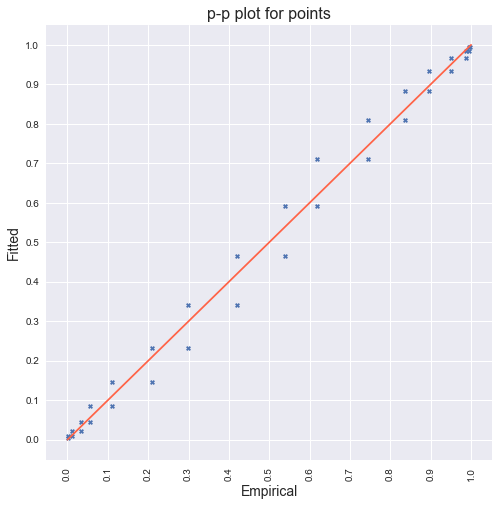

In [16]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pp_df.plot(kind='scatter', x='F_star_x', y='F_hat_x', ax=ax, marker='X')
forty_five_line_df.plot(kind='line', x='x', y='y', ax=ax, color='tomato')
ax.set_ylabel("Fitted", fontsize=14)
ax.set_xticks(np.arange(0, 1.02, 0.10))
ax.set_xticklabels(['%.1f' % f for f in np.arange(0, 1.1, 0.10)], rotation=90)
ax.set_yticks(np.arange(0, 1.02, 0.10))
ax.set_yticklabels(['%.1f' % f for f in np.arange(0, 1.1, 0.10)])
ax.set_xlabel("Empirical", fontsize=14)
ax.legend('')
ax.set_title("p-p plot for points", fontsize=16)
plt.show()

**Conclusion**: We can see that the fitted model is a fairly good fit because most of the values lie near the 45-degree line. However, the deviations start to be apparent where $0.4 \leq F \leq 0.6$.

### Diagnostic Tests - Kolmogorov-Smirnov Goodness of Fit Test

The null hypothesis is the fitted function $\hat{F}(x)$ is close to the empirical function $F^*(x)$. We find the test statistic, $D$ using:

$$
D = \max_{i \in \left\{ 1, \cdots, M\right\}}
\left\{ 
\max 
\begin{pmatrix}
\left|\hat F (x_{(i-1)})- F^*(x_{(i)})\right|, \left|\hat F (x_{(i)})- F^*(x_{(i)})\right|
\end{pmatrix}
\right\}
$$

Note that $M=14$ and $\hat F (x_{(0)}) = 0$

If the true CDF of the data is not $F^*(x)$, then $D$ is large. Given a level of significance $\alpha=0.05$, the null hypothesis that the data has CDF $F^*(x)$ is rejected if $D$ is greater than $\frac{1.36}{\sqrt{M}}$. 

We calculate the value of $D$ to be the largest deviation between $F_i$ and 

In [17]:
pp_df['D'] = (pp_df['F_star_x'] - pp_df['F_hat_x']).abs()
d = pp_df['D'].max()
print(d)

0.09245560874649605


For $\alpha=0.05$, the critical value is:

In [18]:
1.36/(empirical_groupby_df['cum_count'].max())**0.5

0.06403989887132952

And since calculated value of $D=0.0925$ is larger than the critical value, $c=0.0640$, the null hypothesis that the normal distribution is a good fit of the data is rejected in favour of the alternative. 

This is supported with the test statistic and p-value of the `kstest` result.

In [19]:
D_kstest, p_kstest = kstest(us_wines_df['points'], 'norm', args=[fitted_mu, fitted_sigma])
print("D      =%0.4f" % D_kstest)
print("p-value=%0.4f" % p_kstest)

D      =0.0911
p-value=0.0010


The p-value is less than $0.05$, which means the null is rejected in favour of the alternative. That means that the data is not close to the fitted.
<hr>

### References

- Kaggle (https://www.kaggle.com/zynicide/wine-reviews) for dataset
- Yiu (2009). Nonlife Actuarial Models: Theory, Methods and Evaluation, Chap. 13